Data loaded successfully.
Plots saved as 'pareto_and_efficiency_v4_enhanced.png'


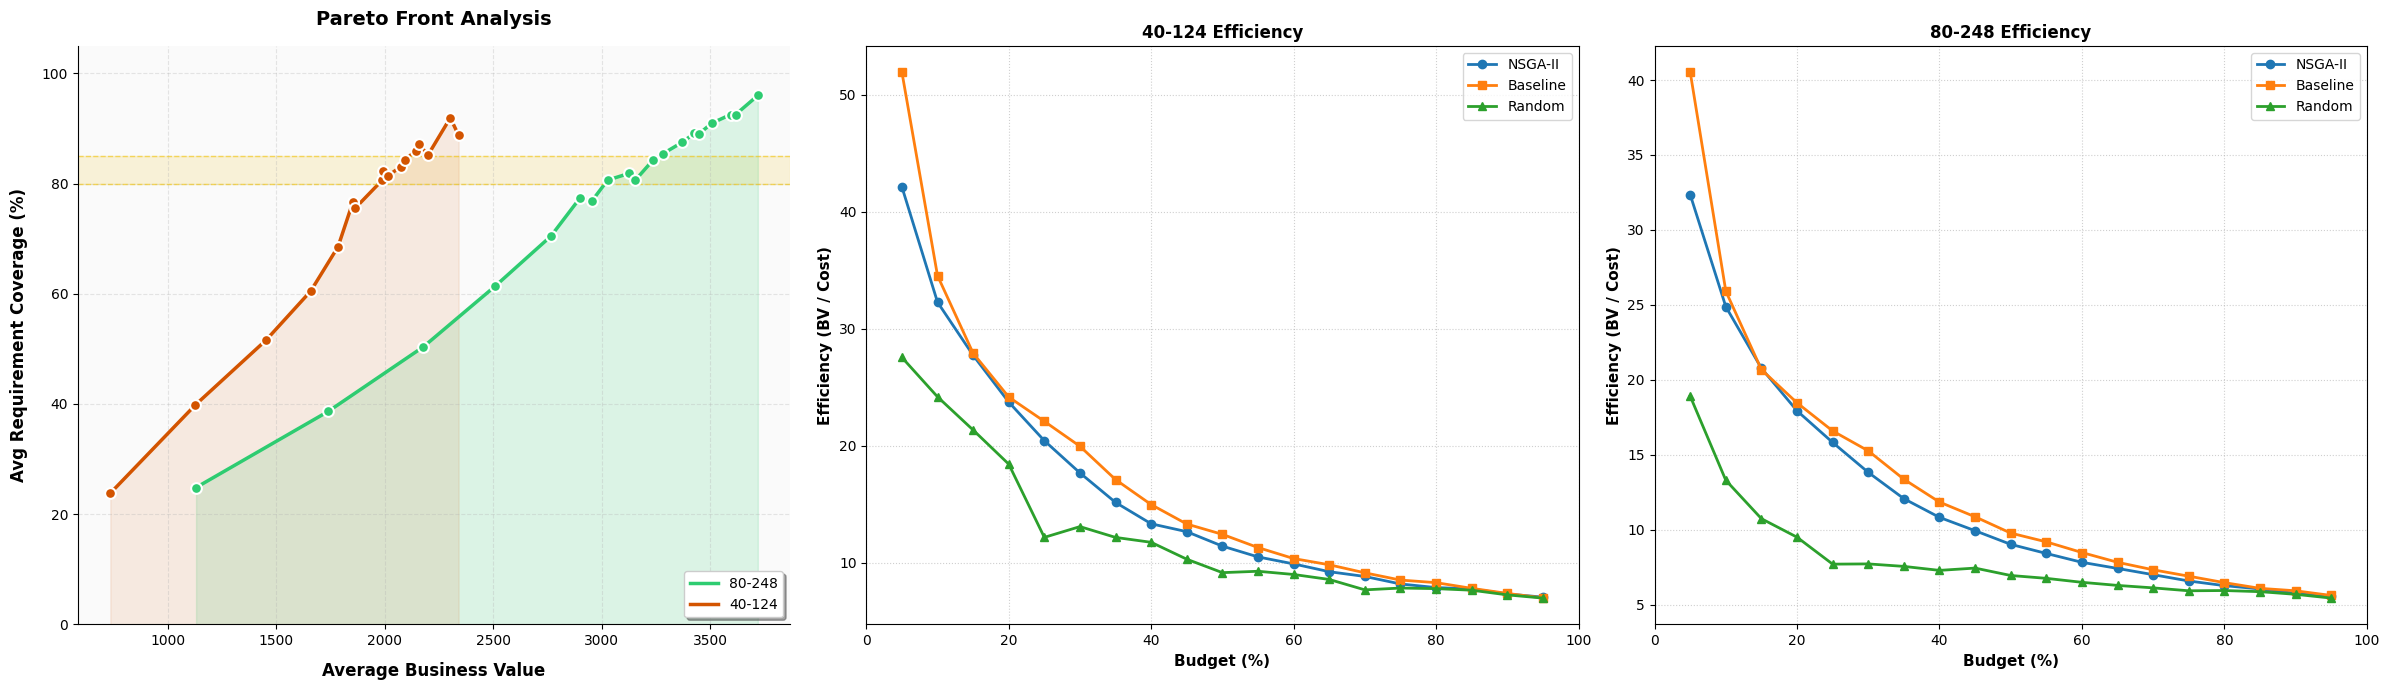

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

def load_data():
    """Load the CSV/Excel files."""
    try:
        # Define file paths as variables
        path_half_summary = 'your_dataset_path'
        path_full_summary = 'your_dataset_path'

        path_half_bcpso = 'your_dataset_path'
        path_full_bcpso = 'your_dataset_path'

        path_half_rand = 'your_dataset_path'
        path_full_rand = 'your_dataset_path'

        # Loading
        # Note: Handling potential sheet loading issues
        half_summary = pd.read_csv(path_half_summary)
        full_summary = pd.read_csv(path_full_summary)

        half_bcpso = pd.read_excel(path_half_bcpso, sheet_name=0)
        full_bcpso = pd.read_excel(path_full_bcpso, sheet_name=0)

        half_rand = pd.read_excel(path_half_rand, sheet_name=0)
        full_rand = pd.read_excel(path_full_rand, sheet_name=0)

        print("Data loaded successfully.")
        return half_summary, full_summary, half_bcpso, full_bcpso, half_rand, full_rand

    except Exception as e:
        print(f"Error loading files: {e}")
        return None, None, None, None, None, None

def standardize_columns(df, name_type):
    """
    Renames columns to standard: 'Budget_%', 'Budget_Value', 'avg_BV', 'avg_req_cvg'
    """
    if df is None:
        return None

    # Strip whitespace
    df.columns = [str(c).strip() for c in df.columns]

    # Aggregation for Raw Random Data
    if name_type == 'random' and 'total_business_value' in df.columns and 'run' in df.columns:
        budget_col = 'budget_pct' if 'budget_pct' in df.columns else 'Budget_%'
        if budget_col in df.columns:
            df = df.groupby(budget_col, as_index=False).agg({
                'total_business_value': 'mean',
                'req_coverage_pct': 'mean'
            })
            df.rename(columns={'total_business_value': 'avg_BV', 'req_coverage_pct': 'avg_req_cvg'}, inplace=True)

    # Column Mapping
    # Standard Names: Budget_%, Budget_Value, avg_BV, avg_req_cvg

    col_map = {
        'Budget_%': ['budget_%', 'budget %', 'budget', 'time budget %', 'budget_pct'],
        'Budget_Value': ['budget_value', 'cost'],
        'avg_BV': ['avg_bv', 'mean_bv', 'average bv', 'mean_atomic_bv', 'total atomic bv', 'mean fully covered bv', 'total_business_value'],
        'avg_req_cvg': ['avg_req_cvg', 'mean_req_cvg', 'mean_atomic_req_cov', 'atomic req coverage %', 'req_coverage_pct']
    }

    for target, aliases in col_map.items():
        if target in df.columns: continue
        for col in df.columns:
            if col.lower() in [a.lower() for a in aliases]:
                df.rename(columns={col: target}, inplace=True)
                break

    return df.sort_values(by='Budget_%') if 'Budget_%' in df.columns else df

def add_efficiency(df, budget_map=None):
    """
    Calculates Efficiency = avg_BV / Budget_Value.
    If Budget_Value is missing, tries to map it using Budget_% and the provided map.
    """
    if df is None or 'Budget_%' not in df.columns:
        return df

    # Map Budget_Value if missing and map is provided
    if 'Budget_Value' not in df.columns and budget_map is not None:
        df['Budget_Value'] = df['Budget_%'].map(budget_map)

    # Calculate Efficiency if both columns exist
    if 'avg_BV' in df.columns and 'Budget_Value' in df.columns:
        df['Efficiency'] = df['avg_BV'] / df['Budget_Value']

    return df

# ============================================================================
# MAIN EXECUTION
# ============================================================================

# 1. Load Data
h_sum, f_sum, h_bcpso, f_bcpso, h_rand, f_rand = load_data()

if h_sum is None: sys.exit("Critical Error: Data load failed.")

# 2. Standardize Columns
h_sum = standardize_columns(h_sum, 'summary')
f_sum = standardize_columns(f_sum, 'summary')
h_bcpso = standardize_columns(h_bcpso, 'bcpso')
f_bcpso = standardize_columns(f_bcpso, 'bcpso')
h_rand = standardize_columns(h_rand, 'random')
f_rand = standardize_columns(f_rand, 'random')

# 3. Create Budget Value Maps (from Summary files which likely have Cost)
# This allows us to calculate efficiency for datasets that only have Budget%
h_budget_map = dict(zip(h_sum['Budget_%'], h_sum['Budget_Value'])) if 'Budget_Value' in h_sum.columns else None
f_budget_map = dict(zip(f_sum['Budget_%'], f_sum['Budget_Value'])) if 'Budget_Value' in f_sum.columns else None

# 4. Calculate Efficiency (Col D / Col C)
h_sum = add_efficiency(h_sum)
h_bcpso = add_efficiency(h_bcpso, h_budget_map)
h_rand = add_efficiency(h_rand, h_budget_map)

f_sum = add_efficiency(f_sum)
f_bcpso = add_efficiency(f_bcpso, f_budget_map)
f_rand = add_efficiency(f_rand, f_budget_map)

# ============================================================================
# PLOTTING
# ============================================================================

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))

# --- PLOT 1: Pareto Front (Left) - ENHANCED VISUALIZATION ---
# Using h_sum and f_sum as requested (Col E vs Col D)

# Style tweaks for Ax1
ax1.grid(True, linestyle='--', alpha=0.3, zorder=0)
ax1.set_facecolor('#fafafa') # Very light grey background for contrast

# FullSize (Enhanced with Area Fill and markers)
if 'avg_BV' in f_sum.columns and 'avg_req_cvg' in f_sum.columns:
    # Sort for smooth fill
    f_sorted = f_sum.sort_values(by='avg_BV')

    # Fill area under curve
    ax1.fill_between(f_sorted['avg_BV'], f_sorted['avg_req_cvg'], color='#2ecc71', alpha=0.15, zorder=1)

    # Main line
    ax1.plot(f_sorted['avg_BV'], f_sorted['avg_req_cvg'],
             linewidth=2.5, color='#2ecc71', label='80-248', zorder=2)

    # Distinct markers
    ax1.scatter(f_sorted['avg_BV'], f_sorted['avg_req_cvg'],
                s=60, color='#2ecc71', edgecolor='white', linewidth=1.5, zorder=3)

# HalfSize (Enhanced)
if 'avg_BV' in h_sum.columns and 'avg_req_cvg' in h_sum.columns:
    # Sort for smooth fill
    h_sorted = h_sum.sort_values(by='avg_BV')

    # Fill area under curve
    ax1.fill_between(h_sorted['avg_BV'], h_sorted['avg_req_cvg'], color='#d35400', alpha=0.1, zorder=1)

    # Main line
    ax1.plot(h_sorted['avg_BV'], h_sorted['avg_req_cvg'],
             linewidth=2.5, color='#d35400', label='40-124', zorder=2)

    # Distinct markers
    ax1.scatter(h_sorted['avg_BV'], h_sorted['avg_req_cvg'],
                s=60, color='#d35400', edgecolor='white', linewidth=1.5, zorder=3)

# Highlight Target Zone (80-85%) with borders and label
ax1.axhspan(80, 85, color='#f1c40f', alpha=0.15, zorder=0)
ax1.axhline(80, color='#f1c40f', linestyle='--', linewidth=1, alpha=0.6)
ax1.axhline(85, color='#f1c40f', linestyle='--', linewidth=1, alpha=0.6)
# Add text annotation for the zone


# Remove top and right spines for cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.set_xlabel('Average Business Value', fontsize=12, fontweight='bold', labelpad=10)
ax1.set_ylabel('Avg Requirement Coverage (%)', fontsize=12, fontweight='bold', labelpad=10)
ax1.set_title('Pareto Front Analysis', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='lower right', frameon=True, fancybox=True, shadow=True)
ax1.set_ylim(0, 105)


# --- PLOT 2: HalfSize Efficiency (Middle) ---
# 3 Lines: Summary, BCPSO, Random
if 'Efficiency' in h_sum.columns:
    ax2.plot(h_sum['Budget_%'], h_sum['Efficiency'],
             linewidth=2, marker='o', label='NSGA-II')

if 'Efficiency' in h_bcpso.columns:
    ax2.plot(h_bcpso['Budget_%'], h_bcpso['Efficiency'],
             linewidth=2, marker='s', label='Baseline')

if 'Efficiency' in h_rand.columns:
    ax2.plot(h_rand['Budget_%'], h_rand['Efficiency'],
             linewidth=2, marker='^', label='Random')

ax2.set_xlabel('Budget (%)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Efficiency (BV / Cost)', fontsize=11, fontweight='bold')
ax2.set_title('40-124 Efficiency', fontsize=12, fontweight='bold')
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.legend(loc='upper right')
ax2.set_xlim(0, 100)

# --- PLOT 3: FullSize Efficiency (Right) ---
# 3 Lines: Summary, BCPSO, Random
if 'Efficiency' in f_sum.columns:
    ax3.plot(f_sum['Budget_%'], f_sum['Efficiency'],
             linewidth=2, marker='o', label='NSGA-II')

if 'Efficiency' in f_bcpso.columns:
    ax3.plot(f_bcpso['Budget_%'], f_bcpso['Efficiency'],
             linewidth=2, marker='s', label='Baseline')

if 'Efficiency' in f_rand.columns:
    ax3.plot(f_rand['Budget_%'], f_rand['Efficiency'],
             linewidth=2, marker='^', label='Random')

ax3.set_xlabel('Budget (%)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Efficiency (BV / Cost)', fontsize=11, fontweight='bold')
ax3.set_title('80-248 Efficiency', fontsize=12, fontweight='bold')
ax3.grid(True, linestyle=':', alpha=0.6)
ax3.legend(loc='upper right')
ax3.set_xlim(0, 100)

plt.tight_layout()
plt.savefig('pareto_and_efficiency_v4_enhanced.png', dpi=300, bbox_inches='tight')
plt.savefig('pareto_and_efficiency_v4_enhanced.pdf', bbox_inches='tight')
print("Plots saved as 'pareto_and_efficiency_v4_enhanced.png'")
plt.show()